# DS-SF-25 | Machine Learning Modeling on the Auto-MPG Dataset | Ivan's Notebook

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model, cross_validation

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'auto-mpg.csv'))

In [3]:
df.shape

(398, 9)

## First thing first: Let's split the dataset into a training set and a testing set...

In [4]:
df = df.sample(frac = .6, random_state = 1)
df.reset_index(inplace = True)

In [5]:
df

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,174,18.0,6,171.0,97.0,2984.0,14.5,75,1,ford pinto
1,359,28.1,4,141.0,80.0,3230.0,20.4,81,2,peugeot 505s turbo diesel
2,250,19.4,8,318.0,140.0,3735.0,13.2,78,1,dodge diplomat
3,274,20.3,5,131.0,103.0,2830.0,15.9,78,2,audi 5000
4,283,20.2,6,232.0,90.0,3265.0,18.2,79,1,amc concord dl 6
...,...,...,...,...,...,...,...,...,...,...
234,47,19.0,6,250.0,100.0,3282.0,15.0,71,1,pontiac firebird
235,113,21.0,6,155.0,107.0,2472.0,14.0,73,1,mercury capri v6
236,177,23.0,4,115.0,95.0,2694.0,15.0,75,2,audi 100ls
237,219,25.5,4,122.0,96.0,2300.0,15.5,77,1,plymouth arrow gs


## `car_name`

In [6]:
df.car_name.value_counts(dropna = False)

ford pinto                  5
toyota corolla              4
dodge colt                  3
amc gremlin                 3
chevrolet impala            3
                           ..
datsun 200-sx               1
plymouth fury gran sedan    1
mazda glc deluxe            1
ford ltd landau             1
ford thunderbird            1
Name: car_name, dtype: int64

## `origin`

In [7]:
df.origin.value_counts(dropna = False)

1    145
3     51
2     43
Name: origin, dtype: int64

## `model_year`

In [8]:
df.model_year.value_counts(dropna = False)

73    26
82    23
78    22
75    20
81    19
      ..
70    17
79    16
72    16
76    15
74    13
Name: model_year, dtype: int64

## (Engine) cylinders, (engine) displacement, (mechanical) horsepower, weight, and acceleration

* Engine cylinders
  * https://en.wikipedia.org/wiki/Cylinder_(engine)
* Engine displacement
  * https://en.wikipedia.org/wiki/Engine_displacement
* Mechanical horsepower
  * https://en.wikipedia.org/wiki/Horsepower#Mechanical_horsepower

In [9]:
df[ ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'] ].corr()

,cylinders,displacement,horsepower,weight,acceleration
cylinders,1.000000,0.950260,0.843206,0.901871,-0.502243
displacement,0.950260,1.000000,0.904913,0.928790,-0.551679
horsepower,0.843206,0.904913,1.000000,0.863121,-0.683395
weight,0.901871,0.928790,0.863121,1.000000,-0.413742
acceleration,-0.502243,-0.551679,-0.683395,-0.413742,1.000000


## `gpm`: Gallons per Mile, Not Miles per Gallon

* Why We Should Measure by Gallons per Mile, Not Miles per Gallon
  * http://www.popularmechanics.com/cars/a12367/4324986/

In [10]:
df['gpm'] = 1. / df.mpg

In [11]:
df.corr().gpm

index          -0.598300
mpg            -0.935521
cylinders       0.842715
displacement    0.867378
horsepower      0.863464
weight          0.887931
acceleration   -0.458860
model_year     -0.593483
origin         -0.558155
gpm             1.000000
Name: gpm, dtype: float64

## `_cbrt`

In [12]:
df[ ['displacement_cbrt' ] ] = df[ ['displacement'] ].apply(np.cbrt)

In [13]:
df[ ['gpm', 'displacement_cbrt'] ].corr()

,gpm,displacement_cbrt
gpm,1.00000,0.86877
displacement_cbrt,0.86877,1.00000


## `cylinders`

In [14]:
df.cylinders.value_counts(dropna = False)

4    125
8     62
6     48
5      2
3      2
Name: cylinders, dtype: int64

## `cylinders` and `gpm`

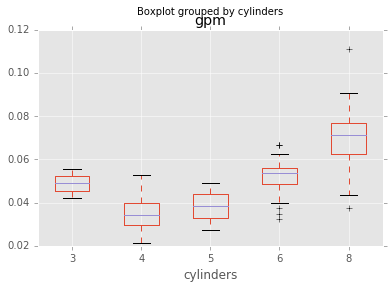

In [15]:
df.boxplot('gpm', by = 'cylinders')

## `displacement` and `gpm`

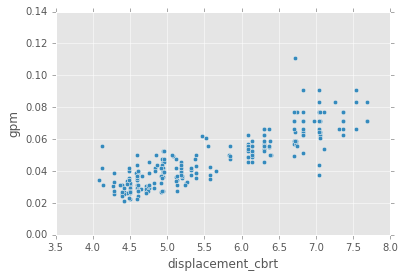

In [16]:
df.plot('displacement_cbrt', 'gpm', kind = 'scatter')

## `horsepower` and `gpm`

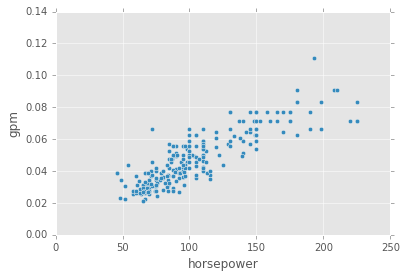

In [17]:
df.plot('horsepower', 'gpm', kind = 'scatter')

## `weight` and `gpm`

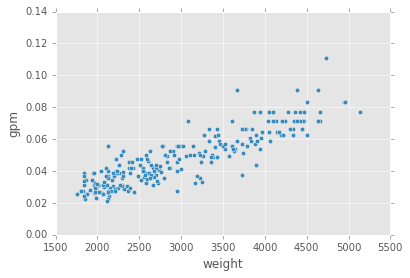

In [18]:
df.plot('weight', 'gpm', kind = 'scatter')

## `gpm`, `cylinders`, `displacement_cbrt`, `horsepower_cbrt`, `weight`

In [19]:
df[ ['gpm', 'cylinders', 'displacement_cbrt', 'horsepower', 'weight'] ].corr()

,gpm,cylinders,displacement_cbrt,horsepower,weight
gpm,1.000000,0.842715,0.868770,0.863464,0.887931
cylinders,0.842715,1.000000,0.950889,0.843206,0.901871
displacement_cbrt,0.868770,0.950889,1.000000,0.880025,0.938419
horsepower,0.863464,0.843206,0.880025,1.000000,0.863121
weight,0.887931,0.901871,0.938419,0.863121,1.000000


In [20]:
smf.ols(formula = 'gpm ~ cylinders + displacement_cbrt + horsepower + weight', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpm   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     275.1
Date:                                   Prob (F-statistic):           1.33e-86
Time:                                   Log-Likelihood:                 835.92
No. Observations:                 236   AIC:                            -1662.
Df Residuals:                     231   BIC:                            -1645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -0.0021      0.005     -0.451      0.653        -0.011     0.007
cylinders             0.0010      0.001      1.160      0.247        -0.001     0.003
displacement_cbrt -7.738e-05      0.002     -0.041      0.968        -0.004     0.004
horsepower            0.0002   2.59e-05      6.026      0.000         0.000     0.000
weight             9.575e-06   1.59e-06      6.033      0.000      6.45e-06  1.27e-05
==============================================================================
Omnibus:                       20.608   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.897
Skew:                           0.536   Prob(JB):                     1.18e-07
Kurtosis:                       4.448   Cond. No.                     3.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Removing `displacement_cbrt`

In [21]:
smf.ols(formula = 'gpm ~ cylinders + horsepower + weight', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpm   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     368.4
Date:                                   Prob (F-statistic):           6.36e-88
Time:                                   Log-Likelihood:                 835.92
No. Observations:                 236   AIC:                            -1664.
Df Residuals:                     232   BIC:                            -1650.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0023      0.002     -1.362      0.174        -0.006     0.001
cylinders      0.0010      0.001      1.519      0.130        -0.000     0.002
horsepower     0.0002   2.48e-05      6.287      0.000         0.000     0.000
weight      9.543e-06   1.37e-06      6.945      0.000      6.84e-06  1.23e-05
==============================================================================
Omnibus:                       20.705   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.200
Skew:                           0.536   Prob(JB):                     1.02e-07
Kurtosis:                       4.458   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interactions

In [22]:
formula = 'gpm ~ cylinders + horsepower + weight'
formula += ' + cylinders * horsepower'
formula += ' + cylinders * weight'
formula += ' + horsepower * weight'
formula += ' + cylinders * horsepower * weight'

smf.ols(formula = formula, data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpm   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     159.1
Date:                                   Prob (F-statistic):           4.87e-84
Time:                                   Log-Likelihood:                 838.37
No. Observations:                 236   AIC:                            -1661.
Df Residuals:                     228   BIC:                            -1633.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       0.0442      0.042      1.052      0.294        -0.039     0.127
cylinders                      -0.0029      0.007     -0.388      0.699        -0.017     0.012
horsepower                     -0.0004      0.000     -0.965      0.335        -0.001     0.000
weight                       -1.57e-05   1.63e-05     -0.962      0.337     -4.79e-05  1.65e-05
cylinders:horsepower          5.93e-05   6.69e-05      0.887      0.376     -7.25e-05     0.000
cylinders:weight             2.651e-06   2.44e-06      1.085      0.279     -2.16e-06  7.47e-06
horsepower:weight            2.994e-07   1.77e-07      1.692      0.092     -4.92e-08  6.48e-07
cylinders:horsepower:weight -3.381e-08   2.38e-08     -1.420      0.157     -8.07e-08  1.31e-08
==============================================================================
Omnibus:                       26.756   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.534
Skew:                           0.646   Prob(JB):                     2.14e-10
Kurtosis:                       4.692   Cond. No.                     2.80e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Removing `cylinders`

In [23]:
smf.ols(formula = 'gpm ~ horsepower + weight', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpm   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     548.4
Date:                                   Prob (F-statistic):           7.57e-89
Time:                                   Log-Likelihood:                 834.75
No. Observations:                 236   AIC:                            -1663.
Df Residuals:                     233   BIC:                            -1653.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0020      0.002     -1.208      0.228        -0.005     0.001
horsepower     0.0002   2.37e-05      7.043      0.000         0.000     0.000
weight      1.088e-05   1.06e-06     10.263      0.000      8.79e-06   1.3e-05
==============================================================================
Omnibus:                       19.398   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.492
Skew:                           0.558   Prob(JB):                     1.77e-06
Kurtosis:                       4.204   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Removing the intercept

In [24]:
model = smf.ols(formula = 'gpm ~ 0 + horsepower + weight', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gpm   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     5903.
Date:                                   Prob (F-statistic):          5.81e-201
Time:                                   Log-Likelihood:                 834.01
No. Observations:                 236   AIC:                            -1664.
Df Residuals:                     234   BIC:                            -1657.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
horsepower     0.0002   2.35e-05      7.287      0.000         0.000     0.000
weight       1.01e-05   8.45e-07     11.958      0.000      8.44e-06  1.18e-05
==============================================================================
Omnibus:                       22.419   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.666
Skew:                           0.616   Prob(JB):                     1.33e-07
Kurtosis:                       4.305   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> An $R^2$ of 98$.  Is that real?  Unfortunately, it isn't:

In [25]:
df.dropna(axis = 0, subset = ['gpm', 'horsepower', 'weight'], inplace = True)

X = df[ ['horsepower', 'weight'] ]
y = df.gpm

model = sm.OLS(y, X).fit()

print model.rsquared, '(reported)'

y_hat = model.predict(X)
print 1 - sum((y - y_hat) ** 2) / sum((y - y.mean()) ** 2), '(calculated)'

0.980565125189 (reported)
0.823678344899 (calculated)


> Why the difference?  When the intercept is forced to 0, `statsmodels` uses $\bar y = 0$ in the $R^2$ formula:

In [26]:
print 1 - sum((y - y_hat) ** 2) / sum((y - 0) ** 2)

0.980565125189


Let's now switch to `sklearn` and use cross-validation.

## `sklearn`

In [27]:
df = pd.read_csv(os.path.join('..', 'datasets', 'auto-mpg.csv'))

In [28]:
df.shape

(398, 9)

In [29]:
df = df.dropna(axis = 0, subset = ['mpg', 'displacement', 'horsepower', 'weight'])

In [30]:
df['gpm'] = 1. / df.mpg
df[ ['displacement_cbrt' ] ] = df[ ['displacement'] ].apply(np.cbrt)

In [31]:
df.shape

(392, 11)

In [32]:
train_df = df.sample(frac = .6, random_state = 1)
test_df = df.drop(train_df.index)

## `horsepower`

In [33]:
train_X = train_df[ ['weight'] ]
train_y = train_df.gpm

model = linear_model.LinearRegression(fit_intercept = False)

cross_validation.cross_val_score(model, train_X, train_y, cv = 5).mean()

0.7542793338182282

> This number is more in line with the $R^2$ value we calculated.  Let's doble check it.

In [34]:
model = linear_model.LinearRegression(fit_intercept = False).fit(train_X, train_y)

print model.score(train_X, train_y)

train_y_hat = model.predict(train_X)
print 1 - sum((train_y - train_y_hat) ** 2) / sum((train_y - train_y.mean()) ** 2)

0.76215554671
0.76215554671


> Again, when the intercept is forced to 0, `statsmodels` uses $\bar y = 0$ in the $R^2$ formula:

In [35]:
model = sm.OLS(train_y, train_X).fit()

print model.rsquared

train_y_hat = model.predict(train_X)
print 1 - sum((train_y - train_y_hat) ** 2) / sum((train_y - 0) ** 2)

0.973792049788
0.973792049788


$R^2$ seems to be off in `statsmodels`...

In [36]:
def linear_model_with_sklearn(names):
    train_X = train_df[ names ]
    train_y = train_df.gpm

    model = linear_model.LinearRegression()

    return cross_validation.cross_val_score(model, train_X, train_y, cv = 5).mean()

In [37]:
print linear_model_with_sklearn(['displacement_cbrt', 'horsepower', 'weight'])
print linear_model_with_sklearn(['horsepower', 'weight'])
print linear_model_with_sklearn(['displacement_cbrt', 'weight'])
print linear_model_with_sklearn(['displacement_cbrt', 'horsepower'])

0.786465476185
0.791039848193
0.747286975128
0.757025372148


## `horsepower` and `weight`

In [38]:
train_X = train_df[ ['horsepower', 'weight'] ]
train_y = train_df.gpm

model = linear_model.LinearRegression()

cross_validation.cross_val_score(model, train_X, train_y, cv = 5).mean()

0.79103984819259709

## `horsepower`, `weight`, and interaction (`horsepower * weight`)

In [39]:
train_df['horsepower * weight'] = train_df.horsepower * train_df.weight

In [40]:
train_X = train_df[ ['horsepower', 'weight', 'horsepower * weight'] ]
train_y = train_df.gpm

model = linear_model.LinearRegression()

cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

0.787103305079351

## `horsepower` and `weight`

In [41]:
train_X = train_df[ ['horsepower', 'weight'] ]
train_y = train_df.gpm

model = linear_model.LinearRegression().fit(train_X, train_y)

model.score(train_X, train_y)

0.81167797659100671

In [42]:
test_X = test_df[ ['horsepower', 'weight'] ]
test_y = test_df.gpm

model.score(test_X, test_y)

0.81741615996353167

In [43]:
X = df[ ['horsepower', 'weight'] ]
y = df.gpm

model = linear_model.LinearRegression().fit(X, y)

model.score(X, y)

0.81514079919703275

In [44]:
print model.intercept_
print model.coef_[0]
print model.coef_[1]

-0.00193323656128
0.000153430105242
1.13269392968e-05


$$gpm = -0.001933 + 0.0001534 * horsepower + 0.00001132 * weight$$